
Partial Credit: Clair J. Sullivan  

# Obtaining the data to test Neo4J

The first portion of this notebook makes a connection to Kaggle for the purpose of downloading the [arXiv dataset](https://www.kaggle.com/Cornell-University/arxiv).  

In order to run it, you will need to have an API key for Kaggle, which we will use to set up the Kaggle CLI in this notebook.  
To get you Kaggle API Token, please create a Kaggle account and then go to Your Account and click on Create New API Token. A file named kaggle.json will get downloaded containing your username and token key. Then upload your file below in the files.upload() function call.

More instructions for how to do this can be found in [this Medium post](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a).

The zipped archive of the dataset is approximately 960 MB and unzipped is approximately 2.6 GB.  You can upload it yourself to Google rather than making the connection via the Kaggle CLI as shown below, but this CLI method is significantly faster.

In [1]:
!pip install -q kaggle
!pip install neo4j-driver
from neo4j import GraphDatabase, basic_auth
!pip install tqdm
!pip install graphdatascience

In [2]:
%matplotlib inline

import json
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from graphdatascience import GraphDataScience as gds

from google.colab import files

## Note
In this next row, you will upload your kaggle.json file associated with your API key to Google, which is used in the following steps.

In [3]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"abhigyaagrawal","key":"618a5de269e7af1be536204ba871ae7e"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                  title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                  Online Food Dataset                                  3KB  2024-03-02 18:50:30          12532        246  0.9411765        
syedanwarafridi/vehicle-sales-data                   Vehicle Sales Data                                  19MB  2024-02-21 20:16:17          21061        362  1.0              
bhavikjikadara/student-study-performance             Student Study Performance                            9KB  2024-03-07 06:14:09           6671        104  1.0              
julianoorlandi/spotify-top-songs-and-audio-features  Spotify

In [5]:
!kaggle datasets download -d Cornell-University/arxiv

100% 1.26G/1.26G [00:23<00:00, 23.8MB/s]
100% 1.26G/1.26G [00:23<00:00, 56.6MB/s]


In [6]:
!unzip \*.zip && rm *.zip

Archive:  arxiv.zip
replace arxiv-metadata-oai-snapshot.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: arxiv-metadata-oai-snapshot.json  


#Functions to clean data

In [7]:
def get_author_list(line):
    # Cleans author dataframe column, creating a list of authors in the row.

    return [e[1] + ' ' + e[0] for e in line]


def get_category_list(line):
    # Cleans category dataframe column, creating a list of categories in the
    # row.

    return list(line.split(" "))

# Data loading and cleaning


Note that `tqdm` is optional, but I like to use it so I can tell where we are in the overall population of the dataframe, knowing that the file is approximately 1.79M rows long.

In [8]:
file = "./arxiv-metadata-oai-snapshot.json"

metadata  = []

lines = 10000    # 10k for testing
with open(file, 'r') as f:
    for line in tqdm(f):
        metadata.append(json.loads(line))
        lines -= 1
        if lines == 0: break

df = pd.DataFrame(metadata)
df.head()

9999it [00:00, 30724.74it/s]


,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,0704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,0704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,0704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,0704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,0704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


In [9]:
df['cleaned_authors_list'] = df['authors_parsed'].map(get_author_list)
df['category_list'] = df['categories'].map(get_category_list)
df = df.drop(['submitter', 'authors', 'comments', 'journal-ref', 'doi',
              'report-no', 'license', 'versions', 'update_date', 'abstract',
              'authors_parsed', 'categories'], axis=1)
df.head()

,id,title,cleaned_authors_list,category_list
0,0704.0001,Calculation of prompt diphoton production cros...,"[C. Balázs, E. L. Berger, P. M. Nadolsky, C. -...",[hep-ph]
1,0704.0002,Sparsity-certifying Graph Decompositions,"[Ileana Streinu, Louis Theran]","[math.CO, cs.CG]"
2,0704.0003,The evolution of the Earth-Moon system based o...,[Hongjun Pan],[physics.gen-ph]
3,0704.0004,A determinant of Stirling cycle numbers counts...,[David Callan],[math.CO]
4,0704.0005,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,"[Wael Abu-Shammala, Alberto Torchinsky]","[math.CA, math.FA]"


# Prepare :Category nodes

In [10]:
categories = pd.DataFrame(df[['category_list']])
categories.rename(columns={'category_list':'category'}, inplace=True)
categories = categories.explode('category').drop_duplicates(subset=['category'])

categories.size

142

In [11]:
categories

,category
0,hep-ph
1,math.CO
1,cs.CG
2,physics.gen-ph
4,math.CA
...,...
6207,cs.FL
6788,cs.OS
6822,q-fin.TR
7291,astro-ph.IM


# Prepare :Author nodes

In [12]:
authors = pd.DataFrame(df[['cleaned_authors_list']])

authors.rename(columns={'cleaned_authors_list':'author'}, inplace=True)
authors=authors.explode('author').drop_duplicates(subset=['author'])

authors.size

24626

# Establish connection to Neo4j Sandbox instance

This demonstrationg uses the [Neo4j Sandbox](https://neo4j.com/sandbox/), but a connection to any running Neo4j database will work, including your local machine.  A Sandbox instance does not last longer than about 3 days, so you will need to populate these values with that of your own instance.

In [13]:
class Neo4jConnection:

    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver( self.__uri, auth=basic_auth(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)

    def close(self):
        if self.__driver is not None:
            self.__driver.close()

    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try:
            session = self.__driver.session(database=db) if db is not None else self.__driver.session()
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally:
            if session is not None:
                session.close()
        return response


In [14]:
# Actually create a connection. Copy uri (with bolt port), username and passwords from your own sandbox instance
conn = Neo4jConnection(uri="bolt://100.24.53.228:7687", user="neo4j", pwd="ditto-increase-laces")

# Queries for adding categories, authors and papers and Populate the database

Populating the database is achieved in three steps.  First, we create all constraints guaranteeing the uniqueness of each node.  Second, we create the each of the nodes themselves.  Finally, we create the relationships between all nodes (`:AUTHORED` and `:IN_CATEGORY`).  

In [15]:
def insert_data(query, rows, batch_size = 10000):
    # Function to handle the updating the Neo4j database in batch mode.

    total = 0
    batch = 0
    start = time.time()
    result = None

    while batch * batch_size < len(rows):

        res = conn.query(query, parameters={'rows': rows[batch*batch_size:(batch+1)*batch_size].to_dict('records')})
        batch += 1
        result = {"batches":batch, "time":time.time()-start}
        print(result)

    return result

def add_categories(categories):
    # Adds category nodes to the Neo4j graph.

    query = '''UNWIND $rows AS row
    MERGE (c:Category {category: toString(row.category)})
    RETURN COUNT(*) as total
    '''

    return conn.query(query, parameters={'rows': categories.to_dict('records')})


def add_authors(rows, batch_size=10000):
    # Adds author nodes to the Neo4j graph as a batch job.

    query = '''UNWIND $rows AS row
               MERGE (:Author {name: row.author})
               RETURN COUNT(*) as total
    '''
    return insert_data(query, rows, batch_size)


def add_papers(rows, batch_size=5000):
    # Adds paper nodes and (:Author)--(:Paper) and (:Paper)--(:Category)
    # relationships to the Neo4j graph as a batch job.  (Note the smaller batch
    # size due to the fact that this function is adding much more data than the
    # add_authors() function.)

    query = '''
    UNWIND $rows as row
    MERGE (p:Paper {id:row.id}) ON CREATE SET p.title = row.title

    // connect categories
    WITH row, p
    UNWIND row.category_list AS category_name
    MATCH (c:Category {category: category_name})
    MERGE (p)-[:IN_CATEGORY]->(c)

    // connect authors
    WITH distinct row, p // reduce cardinality
    UNWIND row.cleaned_authors_list AS author
    MATCH (a:Author {name: author})
    MERGE (a)-[:AUTHORED]->(p)
    RETURN COUNT(distinct p) as total
    '''

    return insert_data(query, rows, batch_size)

In [16]:
conn.query('CREATE CONSTRAINT papers IF NOT EXISTS FOR (p:Paper) REQUIRE p.id IS UNIQUE')
conn.query('CREATE CONSTRAINT authors IF NOT EXISTS FOR (a:Author) REQUIRE a.name IS UNIQUE')
conn.query('CREATE CONSTRAINT categories IF NOT EXISTS FOR (c:Category) REQUIRE c.category IS UNIQUE')

[]

In [17]:
add_categories(categories)

[<Record total=142>]

In [18]:
add_authors(authors)

{'batches': 1, 'time': 0.733919620513916}
{'batches': 2, 'time': 2.3489716053009033}
{'batches': 3, 'time': 2.8289437294006348}


{'batches': 3, 'time': 2.8289437294006348}

# Add :Papers nodes and population all relationships

(This might take a few minutes.)

In [19]:
add_papers(df)

{'batches': 1, 'time': 1.5858101844787598}
{'batches': 2, 'time': 3.8157358169555664}


{'batches': 2, 'time': 3.8157358169555664}

# Confirm the database is properly populated with some simple queries

In [21]:
# query_string = '''
# MATCH (c:Category)
# RETURN c.category_name, SIZE(()-[:IN_CATEGORY]->(c)) AS inDegree
# ORDER BY inDegree DESC LIMIT 20
# '''
query_string='''
MATCH (c:Category)
WITH c, [(p)-[:IN_CATEGORY]->(c) | p] AS products
RETURN c.category, size(products) AS inDegree
ORDER BY inDegree DESC LIMIT 20
'''

top_cat_df = pd.DataFrame([dict(_) for _ in conn.query(query_string)])
top_cat_df.head(20)

,c.category,inDegree
0,astro-ph,2064
1,hep-th,996
2,hep-ph,901
3,quant-ph,672
4,gr-qc,558
5,cond-mat.stat-mech,445
6,cond-mat.mtrl-sci,444
7,math-ph,436
8,math.MP,436
9,cond-mat.str-el,419


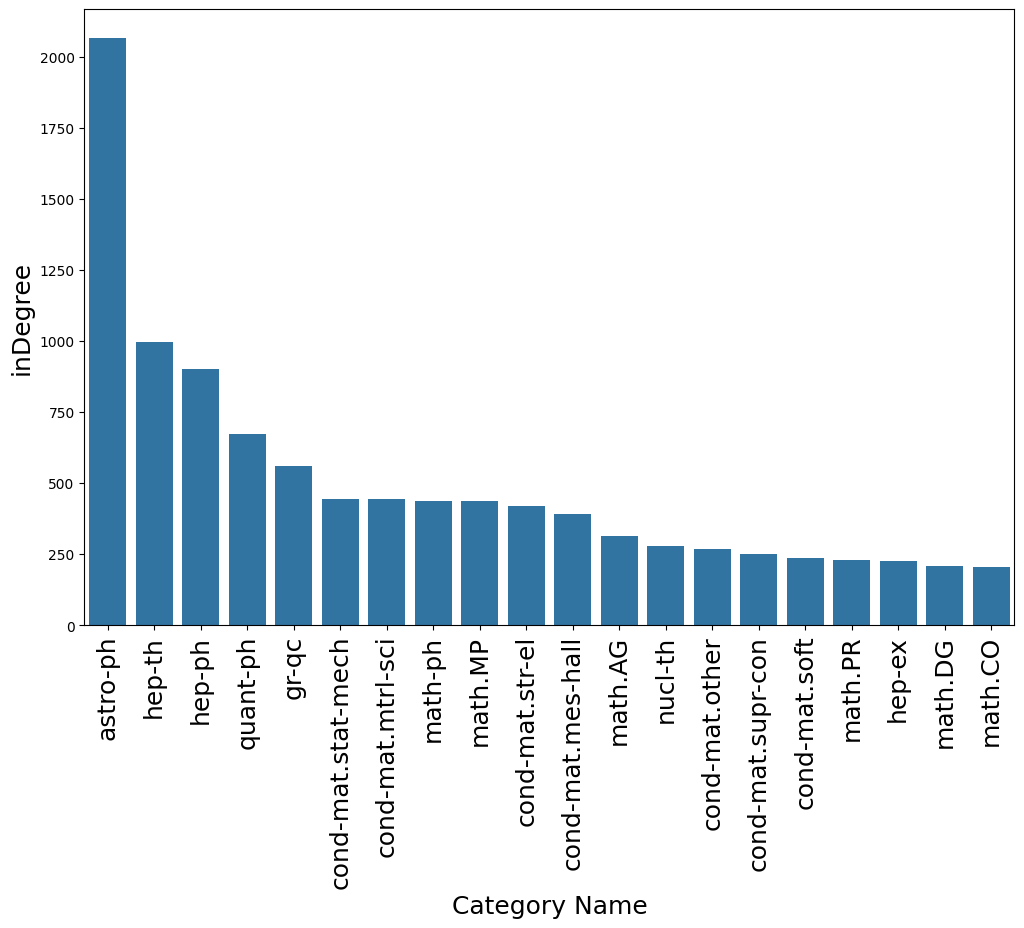

In [22]:
plt.figure(figsize=(12,8))
sns.barplot(x=top_cat_df['c.category'], y=top_cat_df['inDegree'])
plt.xlabel('Category Name', fontsize=18)
plt.ylabel('inDegree',fontsize=18)
plt.xticks(rotation='vertical', fontsize=18)
plt.show()

# Alternative method to read graph data from Neo4j back to Python

In [23]:
result = conn.query(query_string)
print(result)
for record in result:
    print(record[0], record[1])

[<Record c.category='astro-ph' inDegree=2064>, <Record c.category='hep-th' inDegree=996>, <Record c.category='hep-ph' inDegree=901>, <Record c.category='quant-ph' inDegree=672>, <Record c.category='gr-qc' inDegree=558>, <Record c.category='cond-mat.stat-mech' inDegree=445>, <Record c.category='cond-mat.mtrl-sci' inDegree=444>, <Record c.category='math-ph' inDegree=436>, <Record c.category='math.MP' inDegree=436>, <Record c.category='cond-mat.str-el' inDegree=419>, <Record c.category='cond-mat.mes-hall' inDegree=391>, <Record c.category='math.AG' inDegree=313>, <Record c.category='nucl-th' inDegree=277>, <Record c.category='cond-mat.other' inDegree=269>, <Record c.category='cond-mat.supr-con' inDegree=249>, <Record c.category='cond-mat.soft' inDegree=235>, <Record c.category='math.PR' inDegree=228>, <Record c.category='hep-ex' inDegree=224>, <Record c.category='math.DG' inDegree=209>, <Record c.category='math.CO' inDegree=205>]
astro-ph 2064
hep-th 996
hep-ph 901
quant-ph 672
gr-qc 558
